<a href="https://colab.research.google.com/github/s-ambardar/WLASL/blob/main/ASL_Conv3D_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# ASL Conv3D Handshape Classification Model - Vision & Language F20
### Layne Berry, Ethan Blaser, Thrishna Sonnakul, Surya Ambardar
---

# Imports

In [1]:
from google.colab import drive
from google.colab.patches import cv2_imshow
import pandas as pd
import numpy as np
import random
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Conv3D, LSTM, Activation, MaxPooling3D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
import os
import pickle as pkl

# Data

In [2]:
#loading labels pkl file
labels = pkl.load(open('ASL_FINAL_labels.p', 'rb'))

In [3]:
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [4]:
#loading videos dataframe from drive
DATA_PATH = "/content/drive/MyDrive"
infile = open(DATA_PATH+'/ASL/ASL_FINAL_data.p','rb')
final_dataframe = pkl.load(infile)

In [5]:
#1986 video sequences of 9 256x256x3 images, and 1986 labels of 14-length one hot encoded vectors.
print(final_dataframe.shape)
labels.shape

(1986, 9, 256, 256, 3)


(1986, 14)

In [6]:
def hot2label(x):
  shapes = ['0,0-flat','1-D','1-X', '10,A', '15,15-close', '2', '20,G,L', '3-P,K', '5', '5-claw', 'C', '8,8-open', '9', 'None', 'S']
  for i in range(len(x)):
    if x[i] == 1: 
      return(shapes[i])

def delx(x, y):
  for i in range(len(x)):
    if i in y: 
      if i < len(x):
        x.pop(i)
  return x

In [9]:
#Removing indexes with 'None' label
bad_idxs = []
for i in range(len(labels)):
  if hot2label(labels[i]) == 'None':
    bad_idxs.append(i)
print(len(bad_idxs))

158


In [10]:
labels = list(labels)
print(len(labels))
print(len(bad_idxs))
label = delx(labels, bad_idxs)
print(len(label))

print(len(list(final_dataframe)))
dflist = list(final_dataframe)
data = delx(dflist, bad_idxs)
print(len(data))

label = label[:1000]
data = data[:1000]

1986
158
1840
1986
1840


In [56]:
x = np.array(data)
y = np.array(label)

In [24]:
#Scaling all pixel values between 0 and 1
print(x.shape)
print('Min: %.3f, Max: %.3f' % (x.min(), x.max()))
for i in range(1000):
  for j in range(9):
    x[i][j] = x[i][j] / 255.0
print('After scaling: Min: %.3f, Max: %.3f' % (x.min(), x.max()))

(1000, 9, 256, 256, 3)
Min: 0.000, Max: 255.000
After scaling: Min: 0.000, Max: 1.000


In [57]:
#Splitting X and Y into train and validation sets
x_train = x[:len(x)*4//5]
x_val = x[len(x)*4//5:]
y_train = y[:len(x)*4//5]
y_val = y[len(x)*4//5:]

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(800, 9, 256, 256, 3)
(200, 9, 256, 256, 3)
(800, 14)
(200, 14)


# Model Definition and Training

In [59]:
# Defining Conv3D model
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape= (9, 256, 256, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))
model.add(Dropout(0.25))
model.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
#14 categories, so last Dense layer has 14 neurons
model.add(Dense(14, activation='softmax'))

In [61]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr = 0.001), metrics=["accuracy"])
model.fit(x_train, y_train, epochs=20, batch_size = 20, verbose = 1)

Epoch 1/20
40/40 [==============================] - 13s 315ms/step - loss: 3.1252 - accuracy: 0.0825
Epoch 2/20
40/40 [==============================] - 13s 319ms/step - loss: 2.9204 - accuracy: 0.1025
Epoch 3/20
40/40 [==============================] - 13s 318ms/step - loss: 2.8811 - accuracy: 0.1138
Epoch 4/20
40/40 [==============================] - 12s 312ms/step - loss: 2.6966 - accuracy: 0.1838
Epoch 5/20
40/40 [==============================] - 12s 310ms/step - loss: 2.5339 - accuracy: 0.2087
Epoch 6/20
40/40 [==============================] - 12s 309ms/step - loss: 2.2563 - accuracy: 0.3050
Epoch 7/20
40/40 [==============================] - 12s 310ms/step - loss: 1.8396 - accuracy: 0.4000
Epoch 8/20
40/40 [==============================] - 12s 312ms/step - loss: 1.5248 - accuracy: 0.5100
Epoch 9/20
40/40 [==============================] - 13s 314ms/step - loss: 1.2953 - accuracy: 0.5962
Epoch 10/20
40/40 [==============================] - 13s 314ms/step - loss: 1.0352 - accura

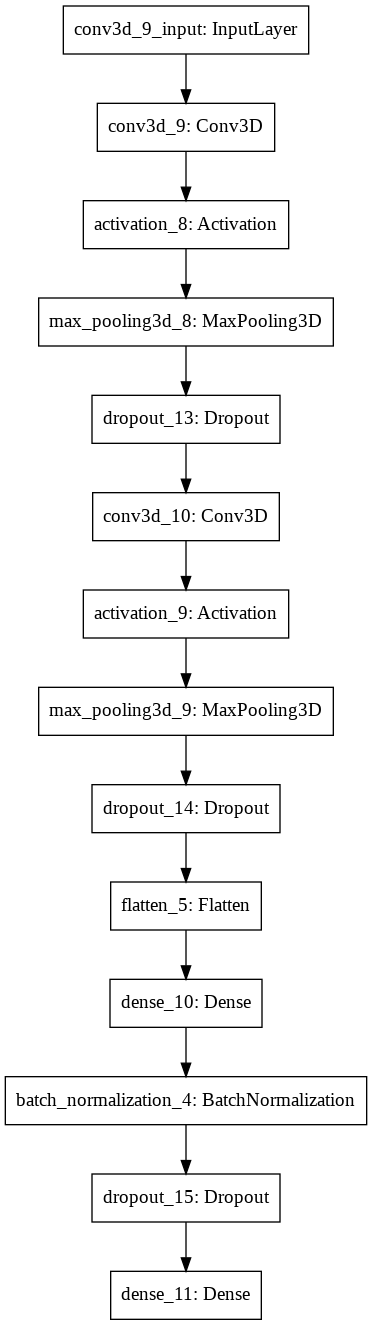

In [65]:
from keras.utils import plot_model
plot_model(model)

# Evaluation

In [73]:
predictions = model.predict(x_val)

In [74]:
for i in range(10):
  pred = predictions[i]
  max = pred.max()
  for j in range(14):
    if pred[j] != max:
      pred[j] = 0
    else:
      pred[j] = 1
  print("Prediction", i)
  print(pred)
  print(y_val[i])
  print("\n")


Prediction 0
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Prediction 1
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


Prediction 2
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Prediction 3
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


Prediction 4
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


Prediction 5
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


Prediction 6
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


Prediction 7
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Prediction 8
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Prediction 9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 

In [76]:
correct = 0
for i in range(10):
  pred = predictions[i]
  max = pred.max()
  for j in range(14):
    if pred[j] != max:
      pred[j] = 0
    else:
      pred[j] = 1
  same = True
  for j in range(len(pred)):
    if pred[j] != y_val[i][j]:
      same = False
  if same:
    correct += 1

print(correct/ 10 * 100, "%")

#shows lower validation accuracy than training accuracy, so model is overfitted

40.0 %


___